In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import glob
import tables
import datetime
from digicamscheduling.utils import time
from astropy.coordinates import EarthLocation
from digicamscheduling.io import reader
import astropy.time
import dateutil.parser
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
plt.style.use('dark_background')

In [ ]:
visibility_dir = '/home/users/l/lacave/PhD/Analysis/SourceSensitivity/LHAASOVisibility'

Text(0, 0.5, 'eff A')

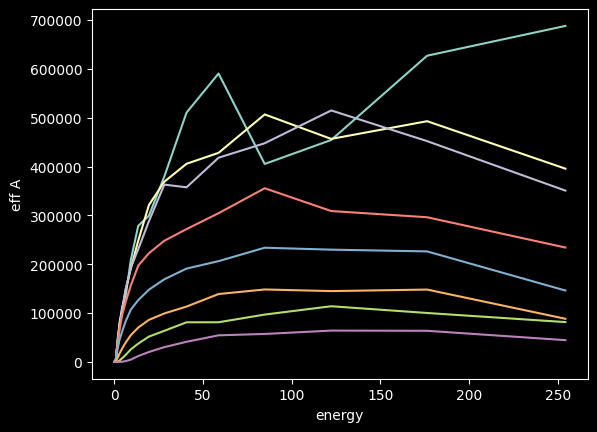

In [2]:
IRF20_file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/IRFs/IRFs/data/sst1m_stereo/0_4/bcf/ze20_az180_nsb100_gc0.75/SST1M_stereo_Zen20deg_gcut0.75_irfs.fits"
IRF30_file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/IRFs/IRFs/data/sst1m_stereo/0_4/bcf/ze30_az180_nsb100_gc0.75/SST1M_stereo_Zen30deg_gcut0.75_irfs.fits"
IRF40_file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/IRFs/IRFs/data/sst1m_stereo/0_4/bcf/ze40_az180_nsb100_gc0.75/SST1M_stereo_Zen40deg_gcut0.75_irfs.fits"
hdul = fits.open(IRF20_file)
effA20table = hdul["EFFECTIVE AREA"]
for i in range(8):
    effA20 = effA20table.data['EFFAREA'][0][i]
    dE20 = effA20table.data['ENERG_HI'][0] - effA20table.data['ENERG_LO'][0]
    # print(effA20)
    # print(dE20)
    plt.plot((effA20table.data['ENERG_HI'][0] + effA20table.data['ENERG_LO'][0])/2, effA20)
hdul.close()
plt.xlabel('energy')
plt.ylabel('eff A')

# LHAASO

In [3]:
#Load json catalog
with open("/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/catalog/LHAASO_SST1M.json", encoding="utf-8-sig") as f:
    sources = json.load(f)
gammacat = pd.DataFrame(sources['sources'])
# gammacat = pd.read_csv("/home/users/l/lacave/PhD/Analysis/SourceSensitivity/HAWC_Catalog/LHAASO_SST1M.csv")
# gammacat['other'] = [x.replace(' ','') for x in gammacat['other']]
print(len(gammacat.index))
print(gammacat.columns)
# print([x.replace(' ','') for x in gammacat['other']])

24
Index(['name', 'ra', 'dec', 'weight', 'other', 'flux', 'flux_at'], dtype='object')


In [26]:
m = 5
last = 31
year = 2024

for d in range(1, last+1, 1):
    gammacat.loc[:,f"integral_visibility_{d:02d}"] = 0
    # visibility_df = pd.DataFrame(columns=['name', 'integral_visibility'])
    if d < last:
        for src in gammacat['name']:
            s = src.replace(" ", "")
            f = f"{visibility_dir}/{s}_{year}-{m:02d}-{d:02d}T12-00-00.000_{year}-{m:02d}-{d+1:02d}T12-00-00.000_visibility.csv"
            visibility_df_temp = pd.read_csv(f, index_col=False)
            visibility_df_temp.replace(0.0, np.nan, inplace=True)
            med_el = visibility_df_temp['elevation'].median()
            if med_el > 40:
                integr = np.sum(visibility_df_temp['source_visibility']*gammacat['integrated_flux'][gammacat['name']==src])*15*60
            else:
                integr = 0
            gammacat.loc[gammacat['name'] == src, f"integral_visibility_{d:02d}"] = integr
    else:
        for src in gammacat['name']:
            s = src.replace(" ", "")
            f = f"{visibility_dir}/{s}_{year}-{m:02d}-{d:02d}T12-00-00.000_{year}-{m+1:02d}-01T12-00-00.000_visibility.csv"
            visibility_df_temp = pd.read_csv(f, index_col=False)
            visibility_df_temp.replace(0.0, np.nan, inplace=True)
            med_el = visibility_df_temp['elevation'].median()
            if med_el > 40:
                integr = np.sum(visibility_df_temp['source_visibility']*gammacat['integrated_flux'][gammacat['name']==src])*15*60
            else:
                integr = 0
            gammacat.loc[gammacat['name'] == src, f"integral_visibility_{d:02d}"] = integr



In [27]:
def plots_LHAASO(data, month, last=31):   
    visibleSources = pd.read_csv("/home/users/l/lacave/PhD/Analysis/SourceSensitivity/HAWC_Catalog/LHAASO_SST1M.csv") 
    data.sort_values('flux', inplace=True, ascending=False)
    coordinates = reader.read_location(filename="/home/users/l/lacave/PhD/digicamscheduling/digicamscheduling/config/digicamextra/location_ondrejov.txt")
    location = EarthLocation(**coordinates)
    colors=["#9e0142", "#f46d43", "#fee08b", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2", "#f0369f"]
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', "August", 'September', 'October', 'November', "December"]
    
    for i in range(1, last +1, 1):
        cols = ['name', 'ra', 'dec', 'r39',  f"integral_visibility_{i:02d}"] #'flux', 'flux_at',
        max_vis_E_df = data
        max_vis_E_df['weigted_visibility'] = max_vis_E_df[f"integral_visibility_{i:02d}"]# * max_vis_E_df['integrated_flux']
        max_vis_E_df = data[data['name'].isin(visibleSources['name'])]
        # ids = []
        # for index, row in max_vis_E_df.iterrows():
        #     n = row['name']
        #     s = n.replace(" ", "")
        #     bools = quand_LHAASO(s, i, row['flux'], SST1M_Sensitivity[7])
        #     if (True in bools) & (row['weigted_visibility'] > 0):
        #         ids.append(index)
        # print(ids)
        fig, axs = plt.subplots(nrows=5, figsize=(12, 17))
        ax = fig.add_subplot(522, projection="mollweide")
        # ax.set_xlim(180, -180)
        ax.grid(color='gray')
        m = 0
        c = 0
        cellColors = []
        idx = 0
        # if len(ids) > 0:
        # print(len(max_vis_E_df))
        # max_vis_E_df = max_vis_E_df.iloc[ids]
        max_vis_E_df = max_vis_E_df[max_vis_E_df[f'integral_visibility_{i:02d}'] > 0]
        # print(len(max_vis_E_df))
        max_vis_E_df.sort_values('weigted_visibility', inplace=True, ascending=False)
    
        for index, row in max_vis_E_df.iterrows():
            color = colors[c%8]
            cellColors.append([color] * len(cols))
            n = row['name']
            s = n.replace(" ", "")
            
            # if True in bools:

            if i == last:
                f = f"{visibility_dir}/{s}_{year}-{month:02d}-{i:02d}T12-00-00.000_{year}-{month+1:02d}-01T12-00-00.000_visibility.csv"
                # bools = quand_LHAASO(s, i, row['flux'], SST1M_Sensitivity[7],)
                visibility_df_temp = pd.read_csv(f, index_col=False)
                visibility_df_temp.replace(0.0, np.nan, inplace=True)
                dt = dateutil.parser.parse(f"'2024-{month:02d}-{i:02d} 12:00'")
                start_date = astropy.time.Time(dt)
                dt = dateutil.parser.parse(f"'2024-{month+1:02d}-01 12:00'")
                end_date = astropy.time.Time(dt)
            else:
                f = f"{visibility_dir}/{s}_{year}-{month:02d}-{i:02d}T12-00-00.000_{year}-{month:02d}-{i+1:02d}T12-00-00.000_visibility.csv"
                # print(f)
                # bools = quand_LHAASO(s, i, row['flux'], SST1M_Sensitivity[7])
                visibility_df_temp = pd.read_csv(f, index_col=False)
                visibility_df_temp.replace(0.0, np.nan, inplace=True)
                dt = dateutil.parser.parse(f"'2024-{month:02d}-{i:02d} 12:00'")
                start_date = astropy.time.Time(dt)
                dt = dateutil.parser.parse(f"'2024-{month:02d}-{i+1:02d} 12:00'")
                end_date = astropy.time.Time(dt)

            date = time.compute_time(date_start=start_date, date_end=end_date,
                                time_step=15*u.min, location=location,
                                only_night=True)
            # print(row['weight'])
            # print(bools)
            # vis = np.array([a * b for a, b in zip(visibility_df_temp['source_visibility'], bools)] * row['weight'])
            vis = visibility_df_temp['source_visibility']
            vis = vis.astype('float')
            # vis[vis == 0.] = np.nan
            # print(vis)
            # el = np.array([a * b for a, b in zip(visibility_df_temp['elevation'], bools)])
            el = visibility_df_temp['elevation']
            el = el.astype('float')
            # el[el == 0.] = np.nan
            # print(el)
            axs[3].plot_date(date.plot_date, vis, label=n, color=color, alpha=1, markeredgewidth=0.0, markersize=len(max_vis_E_df)-idx +5, zorder=idx)
            axs[3].set_xlabel('UTC time')
            axs[4].plot_date(date.plot_date, el, label=n, color=color, alpha=1, markeredgewidth=0.0, markersize=len(max_vis_E_df)-idx +5, zorder=idx)
            axs[4].set_xlabel('UTC time')
            axs[2].plot_date(date.plot_date, visibility_df_temp['source_visibility'] * row['integrated_flux'], label=n, color=color, alpha=1, markeredgewidth=0.0, markersize=len(max_vis_E_df)-idx +5, zorder=idx)
            axs[2].set_xlabel('UTC time')

            c_icrs = SkyCoord(ra=row['ra']*u.degree, dec=row['dec']*u.degree, frame='icrs')
            if row['r39']>0:
                ax.scatter(-c_icrs.galactic.l.wrap_at('180d').radian, c_icrs.galactic.b.wrap_at('180d').radian, color=color, alpha=1, zorder=idx, s=row['r39']*70+30)
            else:
                ax.scatter(-c_icrs.galactic.l.wrap_at('180d').radian, c_icrs.galactic.b.wrap_at('180d').radian, color=color, alpha=1, zorder=idx, marker="x", s=40)
            c+=1
            idx+=1
        axs[3].legend(bbox_to_anchor=(0.3, 4))
        axs[3].set_ylabel('Visibility')
        axs[3].grid()
        axs[3].axes.xaxis.set_ticklabels([])
        axs[2].axes.xaxis.set_ticklabels([])
        axs[3].set_ylim(bottom=0, top=1)
        axs[4].set_ylim((0, 90))
        axs[3].set_xlabel(None)
        axs[2].set_xlabel(None)
        axs[4].set_ylabel('Elevation [deg]')
        axs[4].grid()
        # axs[2].axhline(SST1M_Sensitivity[7], lw=2, color='k')
        # axs[2].set_ylabel(f"Visible FLux at {max_vis_E_df['flux_at'].to_numpy()[0]}TeV [TeV/cm$^2$/s]")
        axs[2].set_ylabel(f"Visible Flux from \n0.1 to 1000 TeV [cm$^{-2}$s$^{-1}$]")
        axs[2].grid()

        

        plt.style.use('classic')
        df_temp = max_vis_E_df[cols]
        df_temp.update(df_temp[['ra', 'dec',f"integral_visibility_{i:02d}"]].astype(float))
        df_temp.update(df_temp[['ra', 'dec', f"integral_visibility_{i:02d}"]].applymap('{:.2E}'.format))
        if len(df_temp)>0:
            table = axs[1].table(cellText=df_temp.values, colLabels=df_temp.columns, loc='center', cellColours=cellColors, alpha=0.1,)
            table.auto_set_font_size(False)
            table.set_fontsize(12)
            table.scale(0.8, 1.2)
            table.auto_set_column_width(col=list(range(len(df_temp.columns))))
        plt.style.use('dark_background')
        # hide axes
        # fig.patch.set_visible(False)
        axs[0].axis('off')
        axs[0].axis('tight')
        axs[1].axis('off')
        axs[1].axis('tight')
        # axs[0].set_title(f"{months[i-1]} 2024", fontsize= 24)
        plt.subplots_adjust(wspace=0, hspace=0)
        # plt.tight_layout()
        # plt.savefig(f"/home/users/l/lacave/PhD/Analysis/SourceSensitivity/BL/BL_{months[i-1]}.pdf", dpi=330)
        plt.show()
        # max_vis_E_df[['name', 'E_WCDA', 'E_KM2A', 'ra', 'dec', 'r39', f"mean_visibility_{i:02d}", "Assoc.(Sep.)"]].to_csv(f"/home/users/l/lacave/PhD/Analysis/SourceSensitivity/visibility/sources_{i:02d}.csv")
        m+=1
        # print(max_vis_E_df[['name', 'E_WCDA', 'E_KM2A', 'ra', 'dec', 'N0']])

## Plots

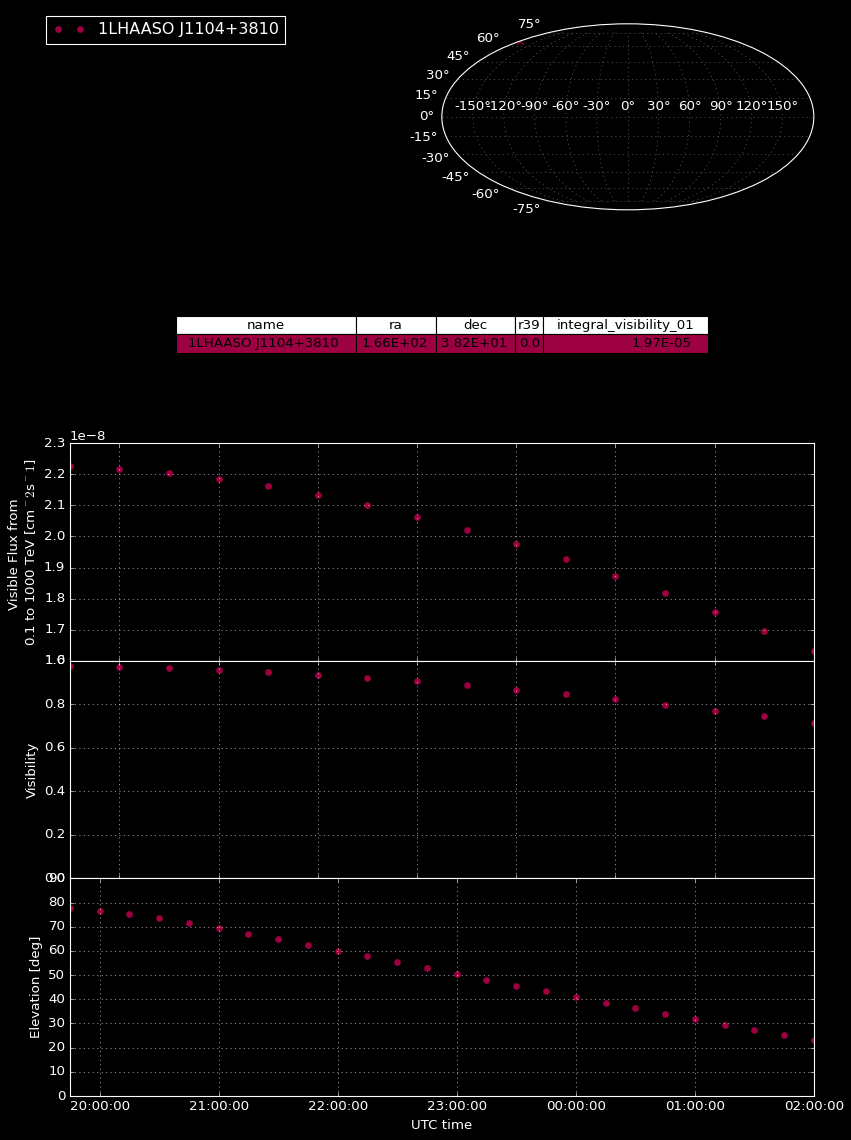

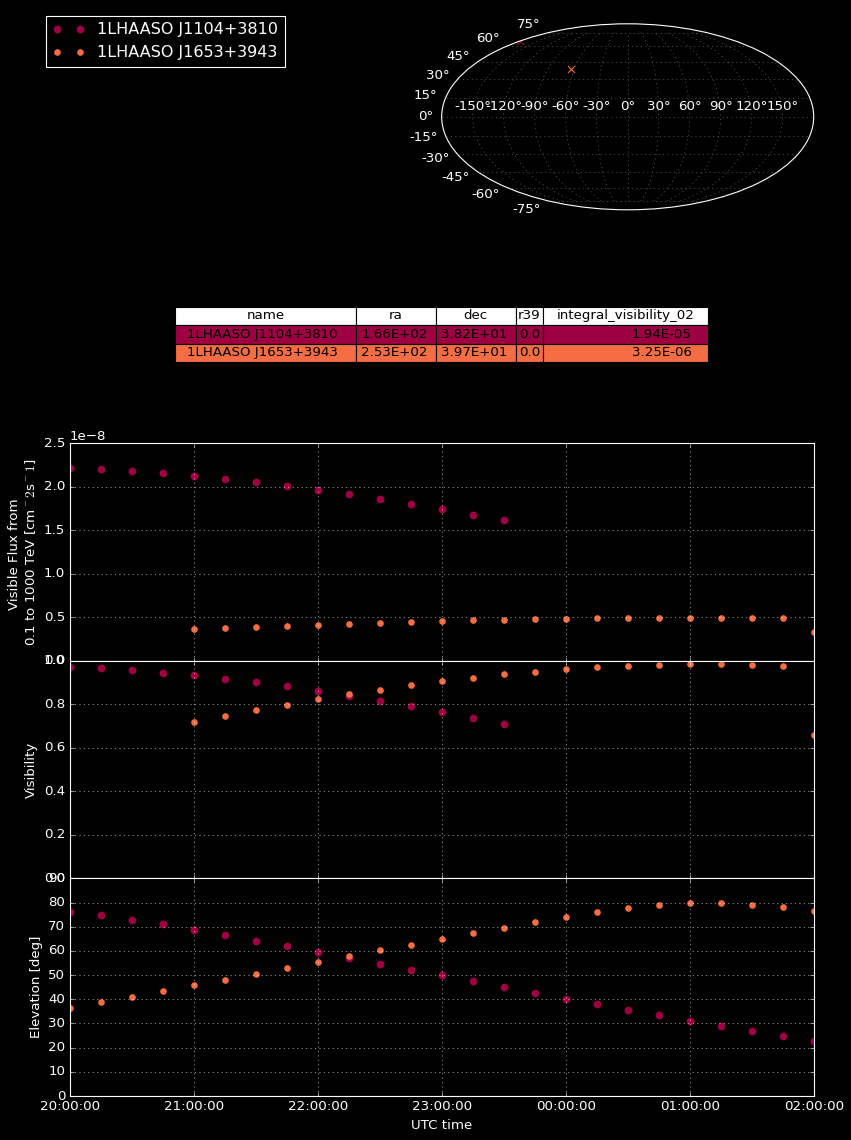

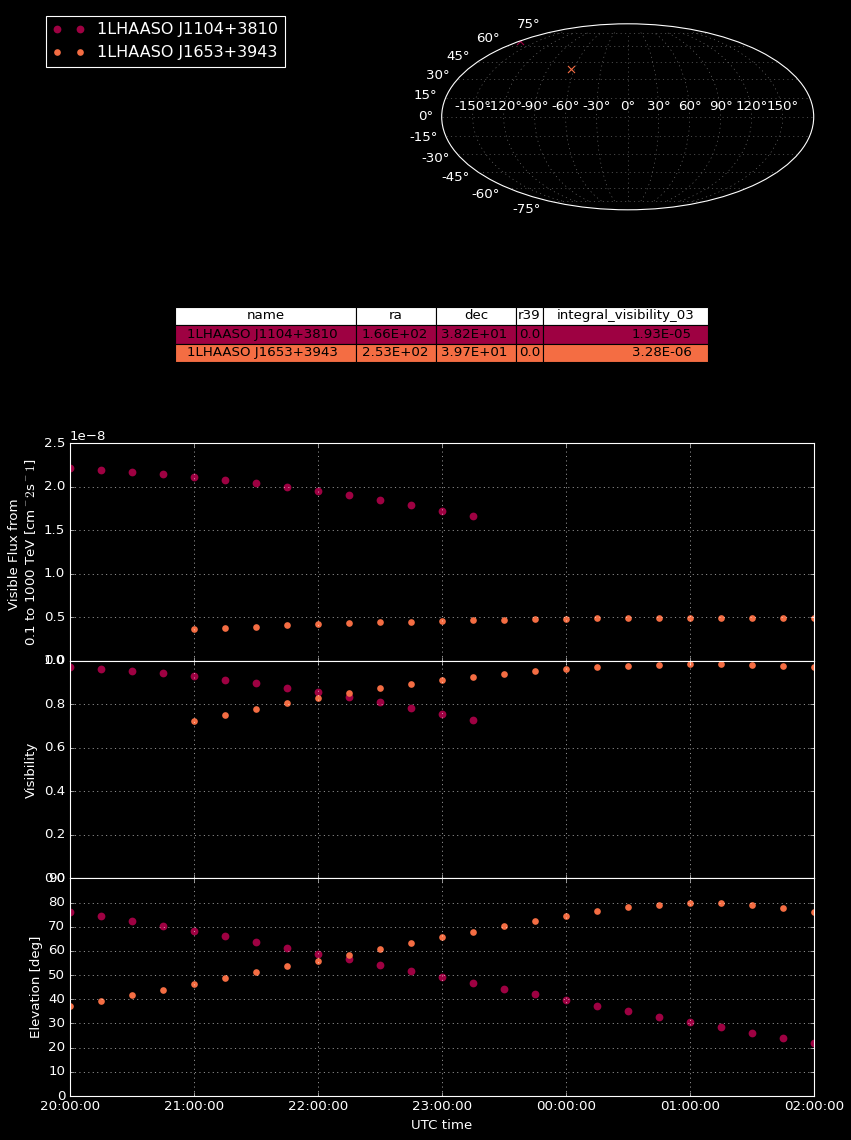

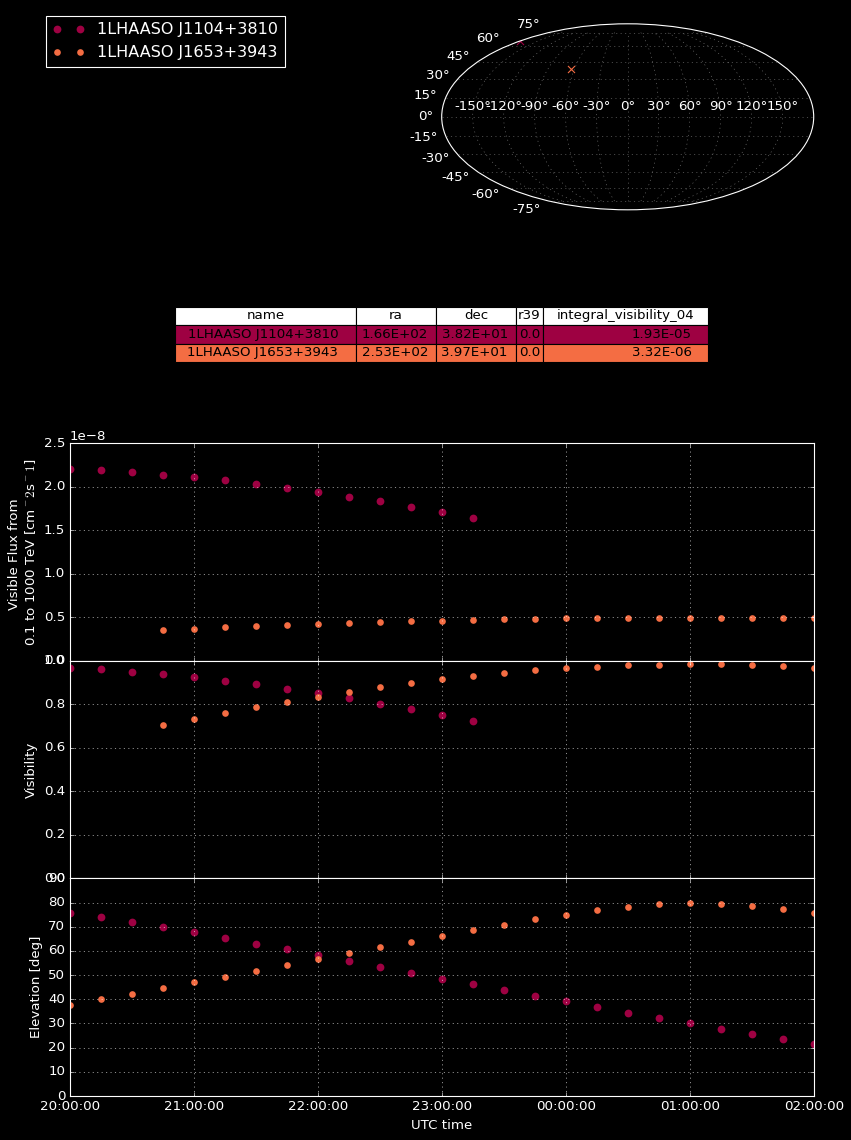

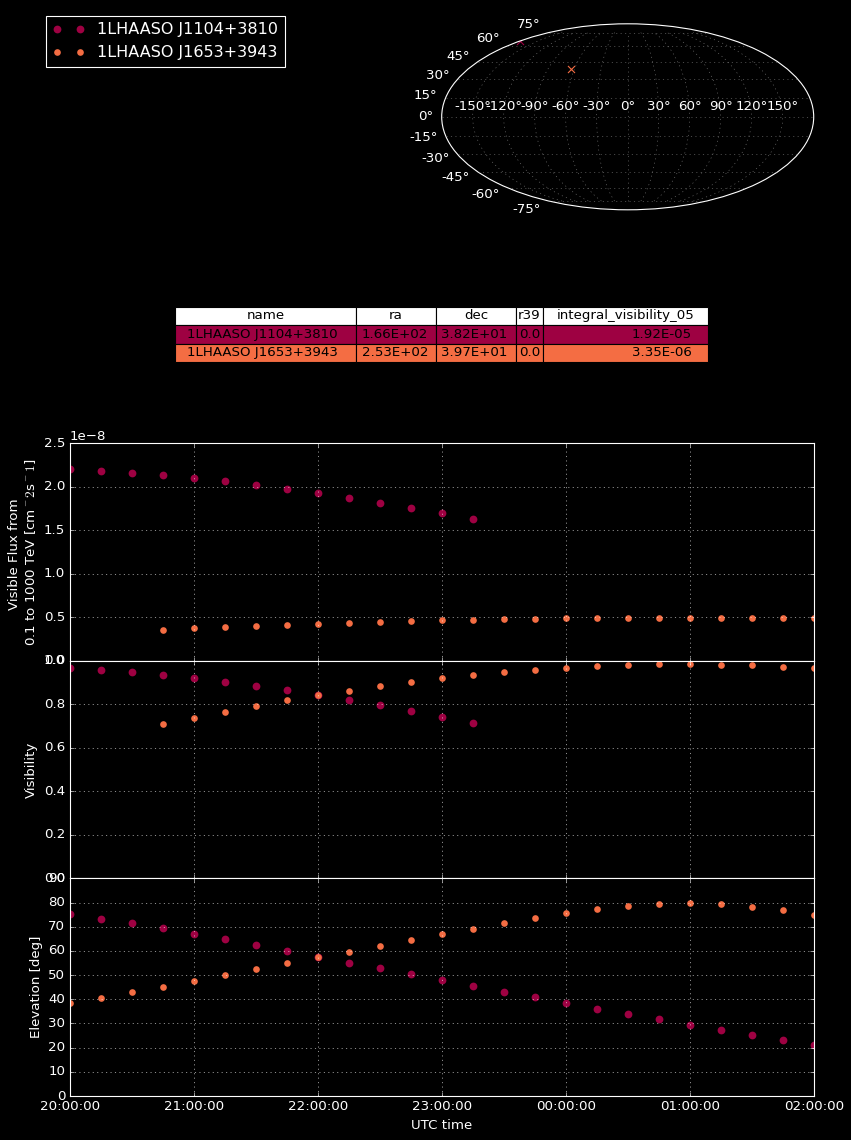

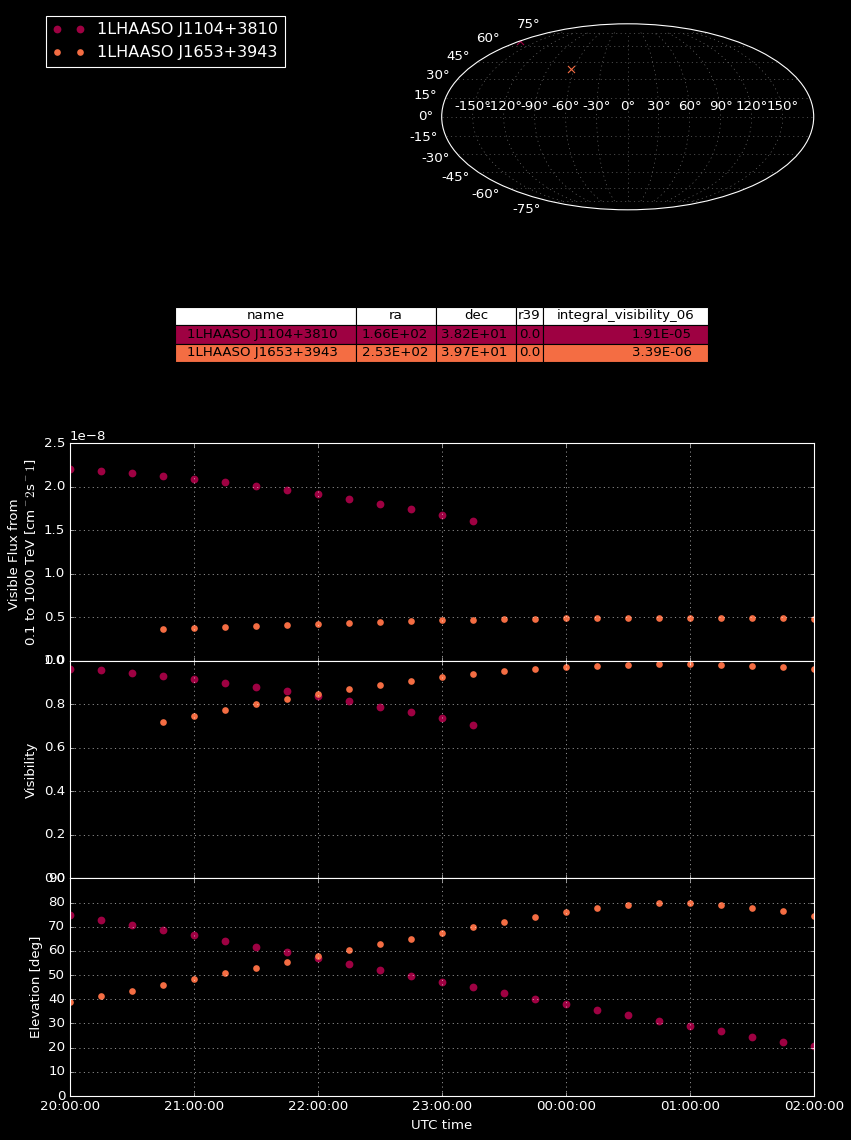

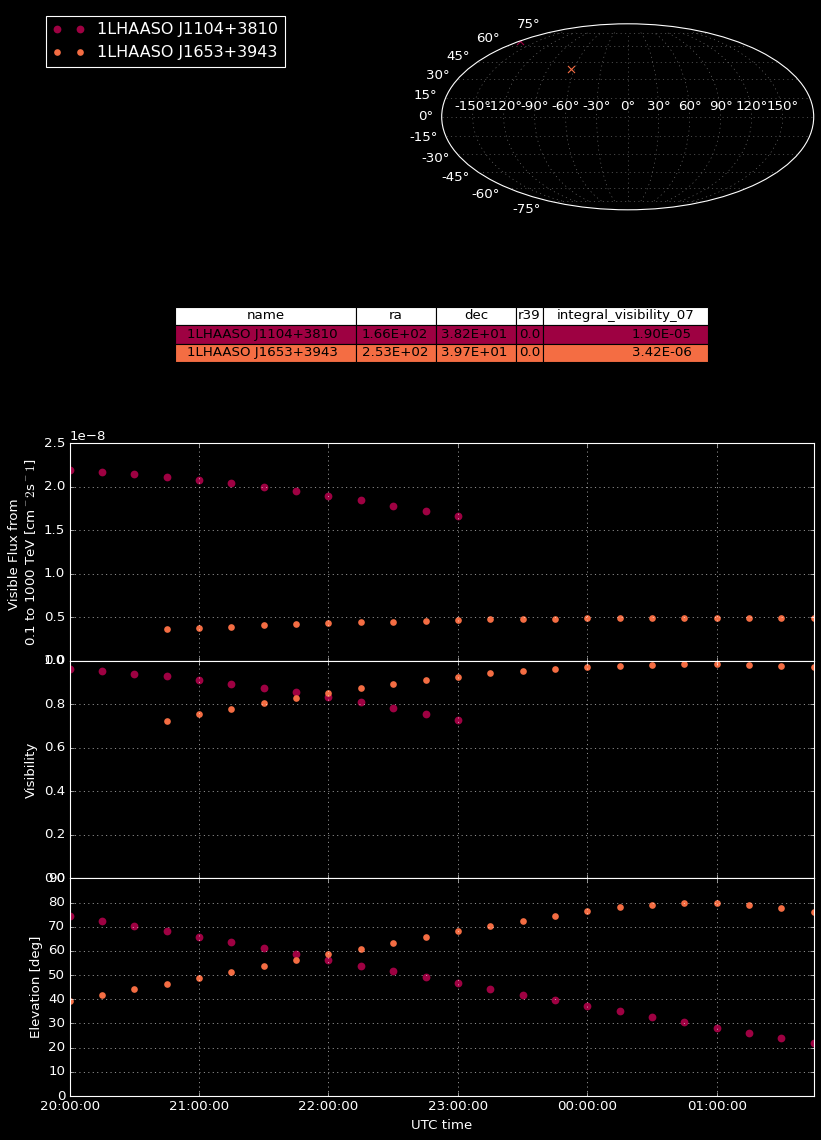

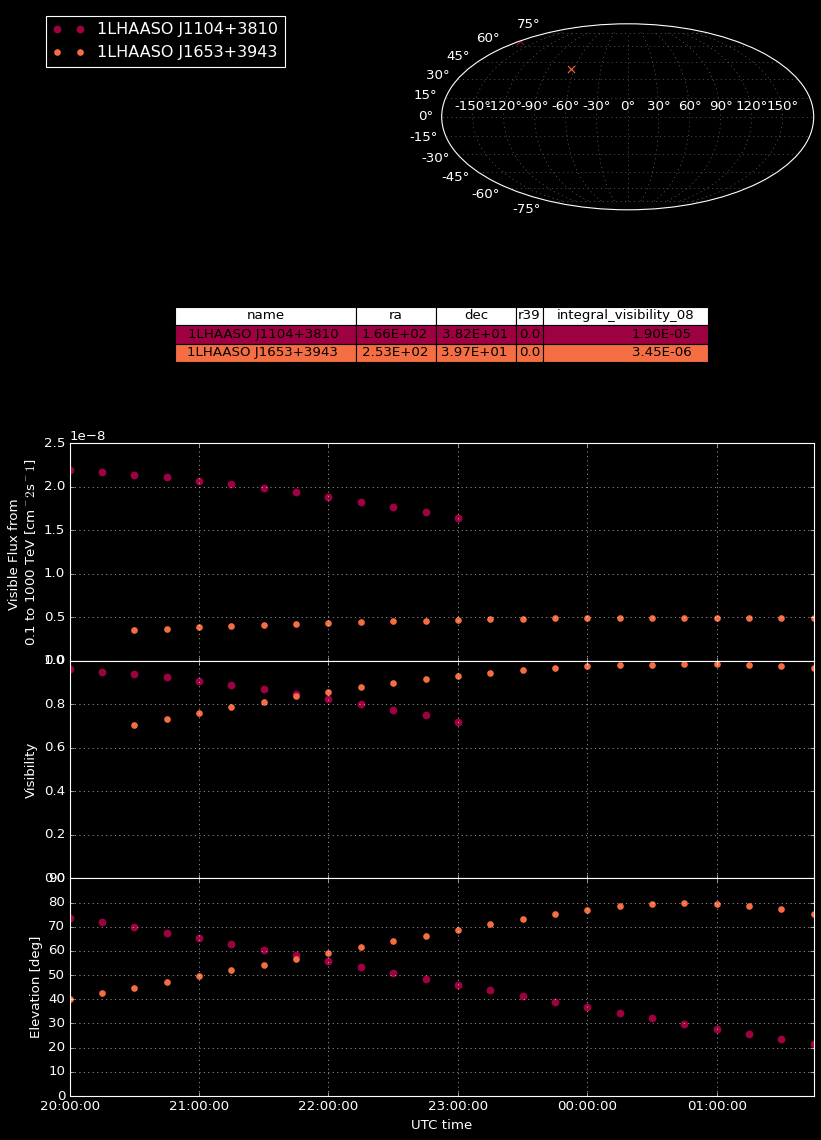

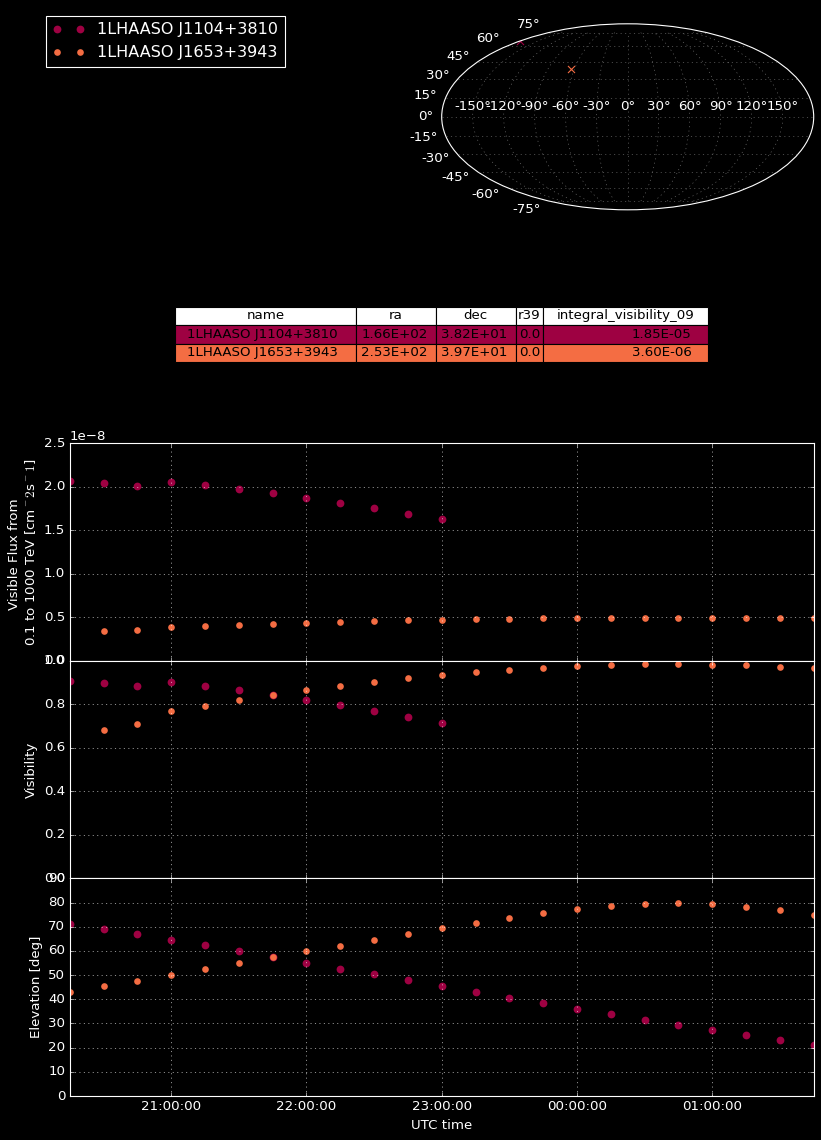

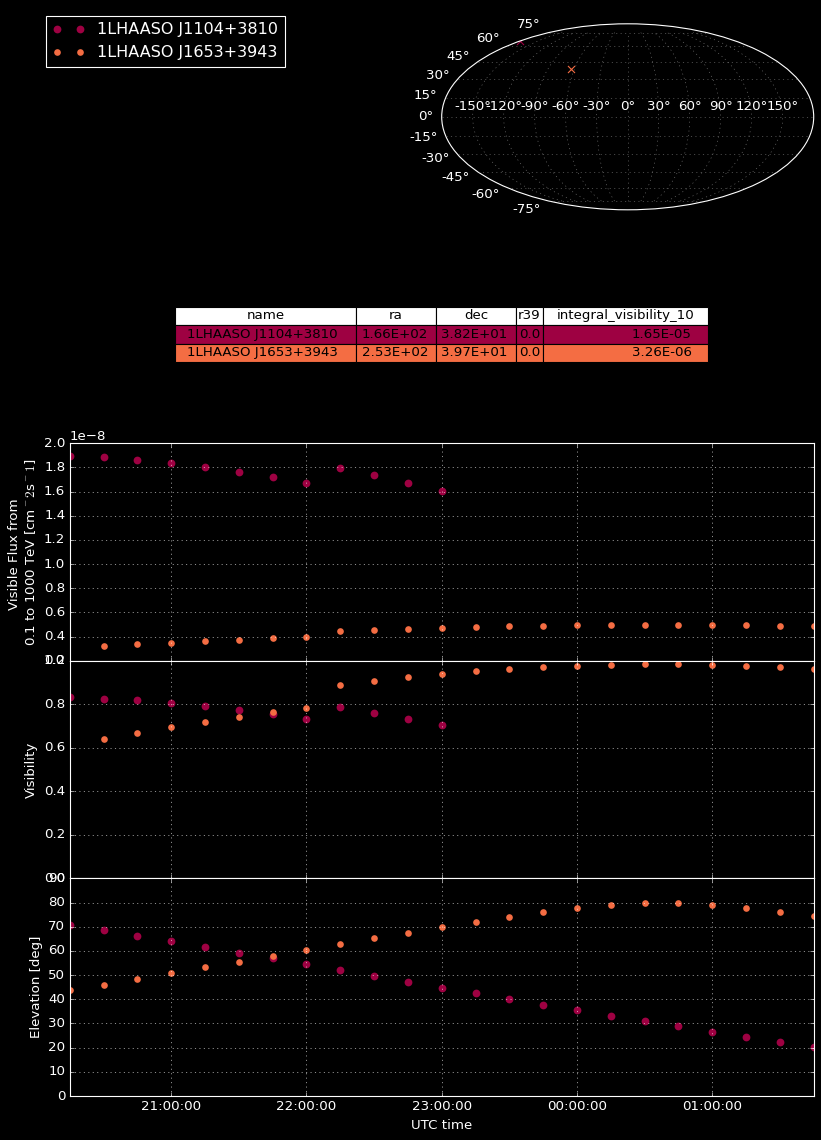

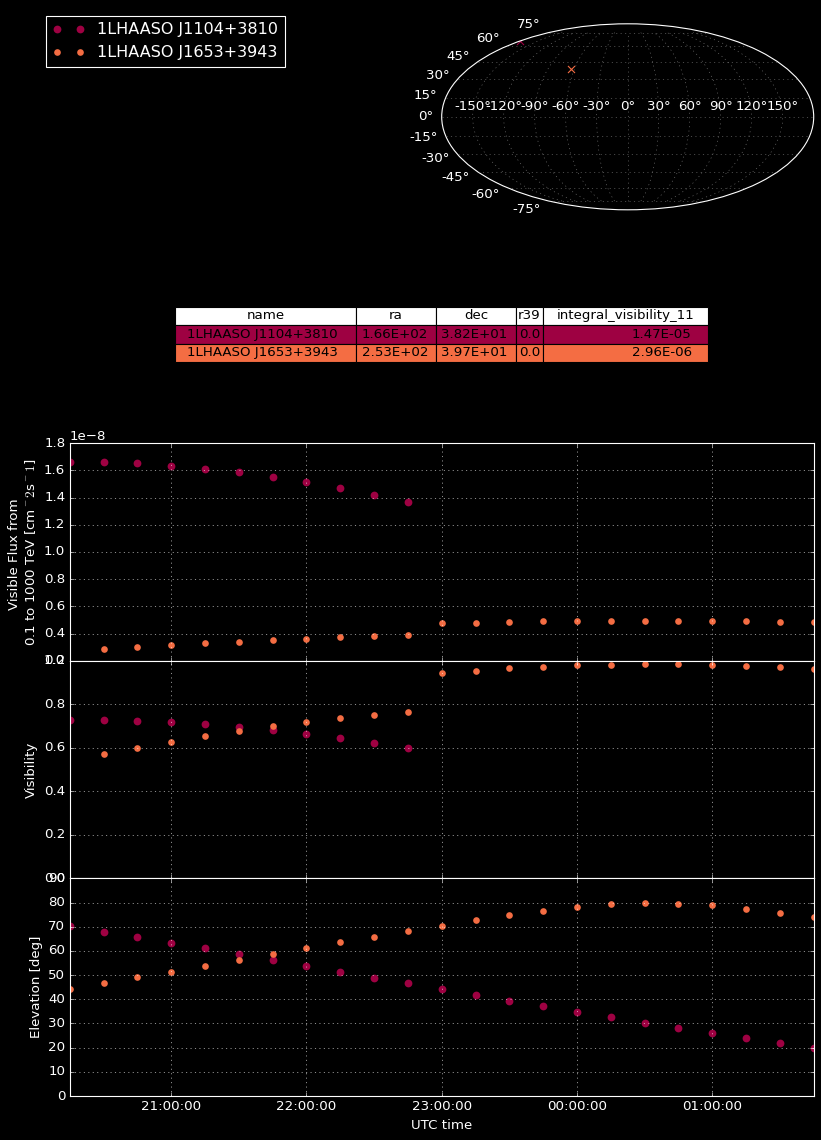

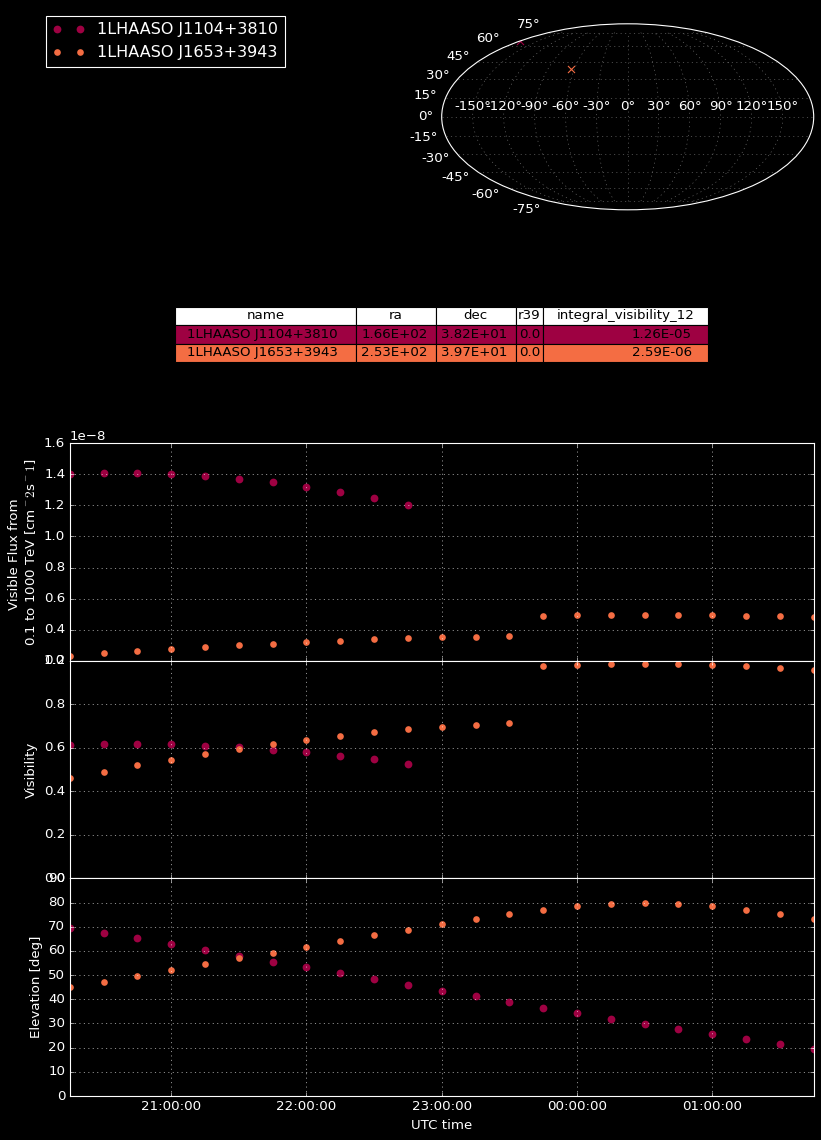

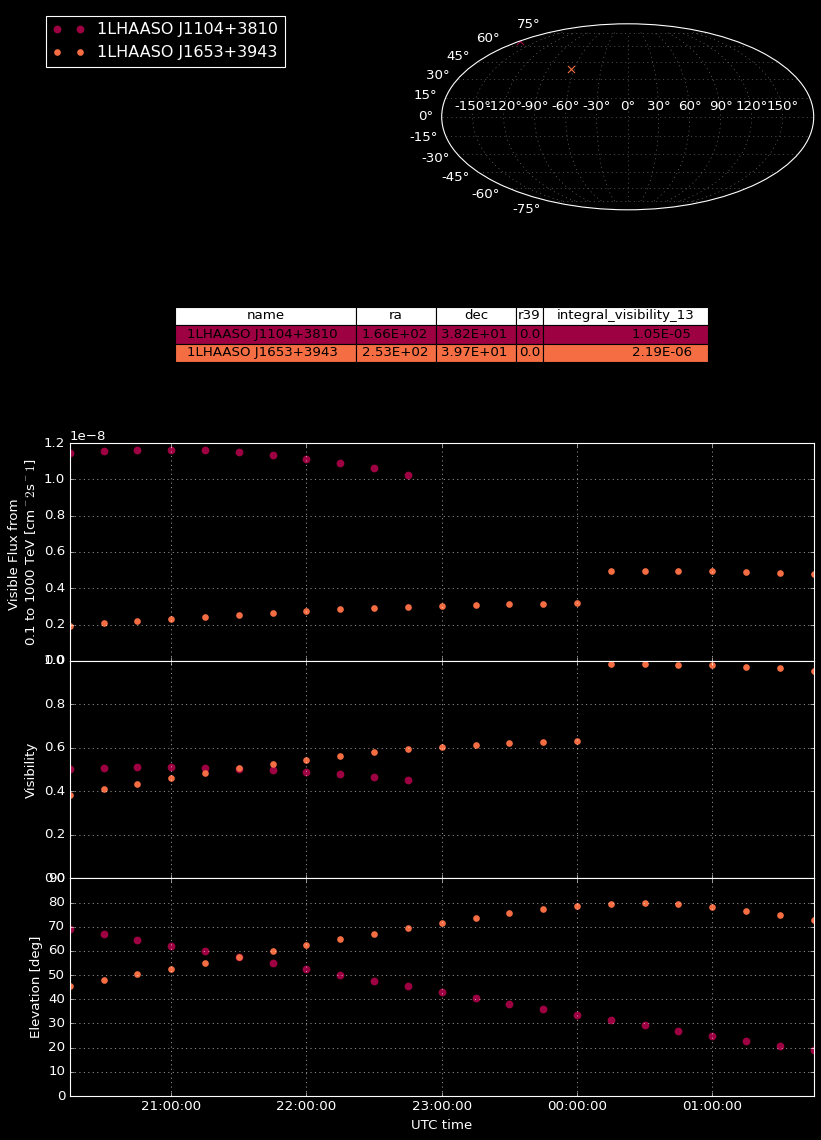

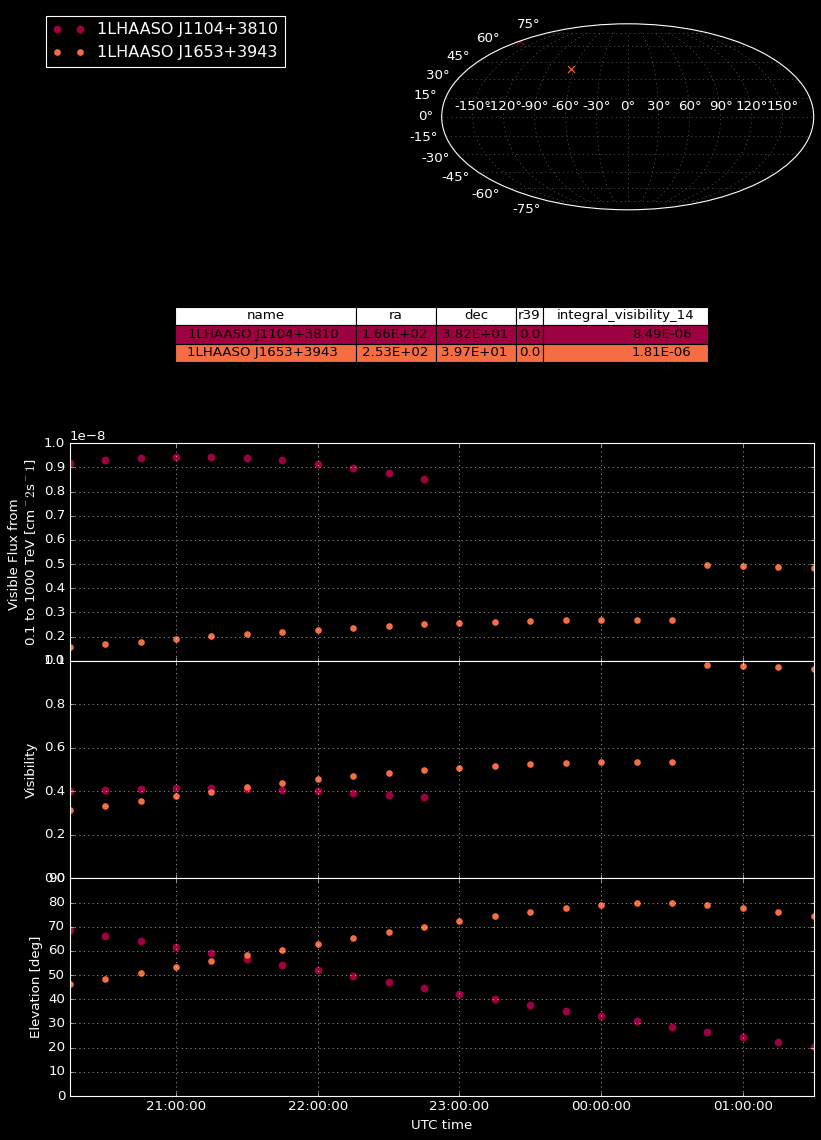

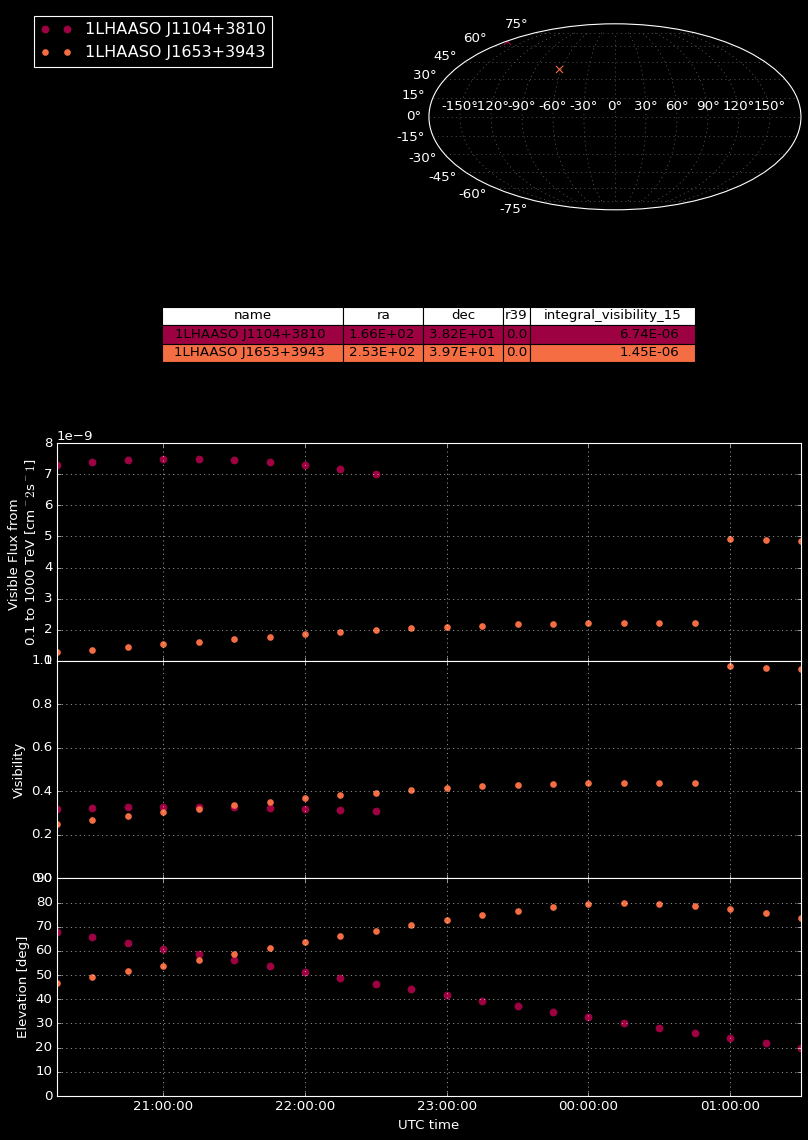

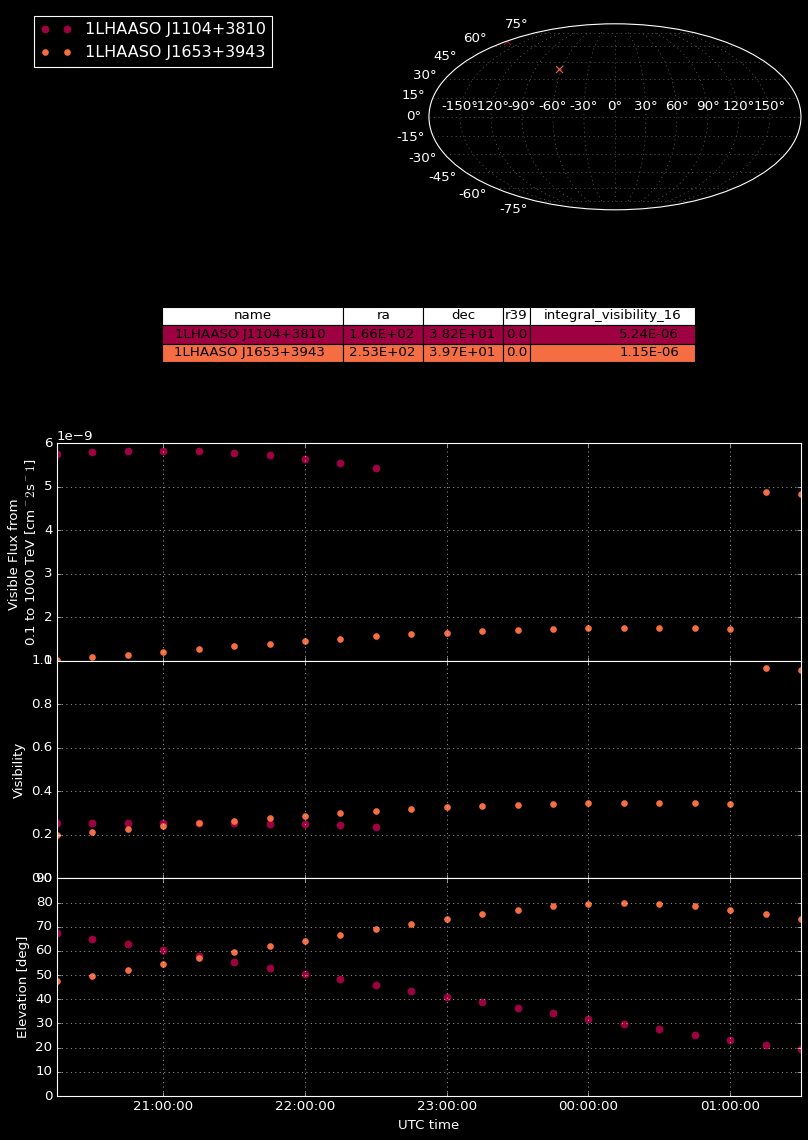

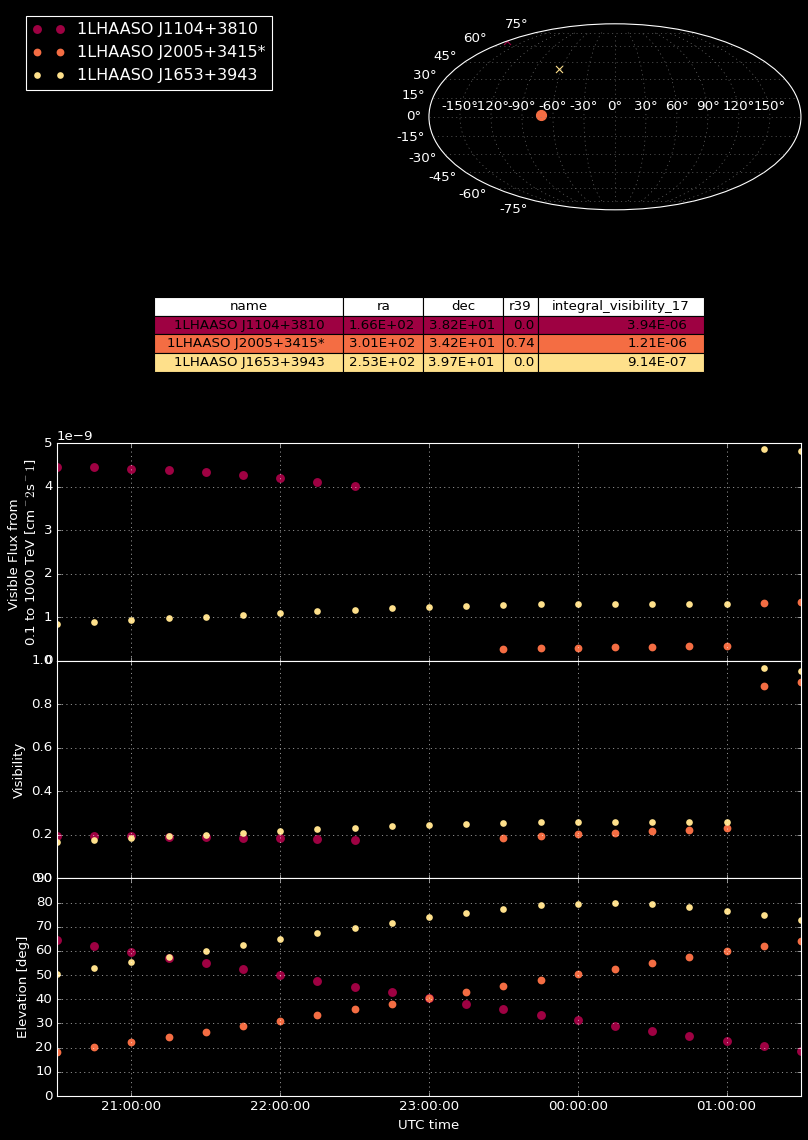

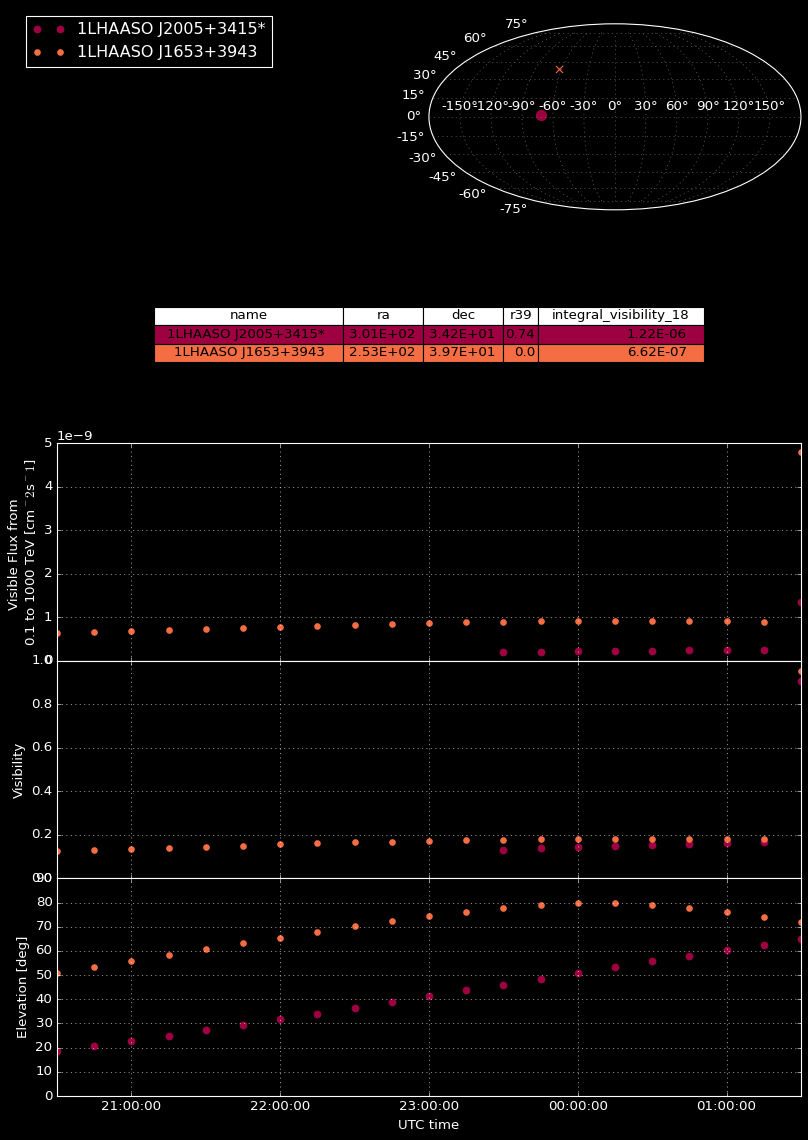

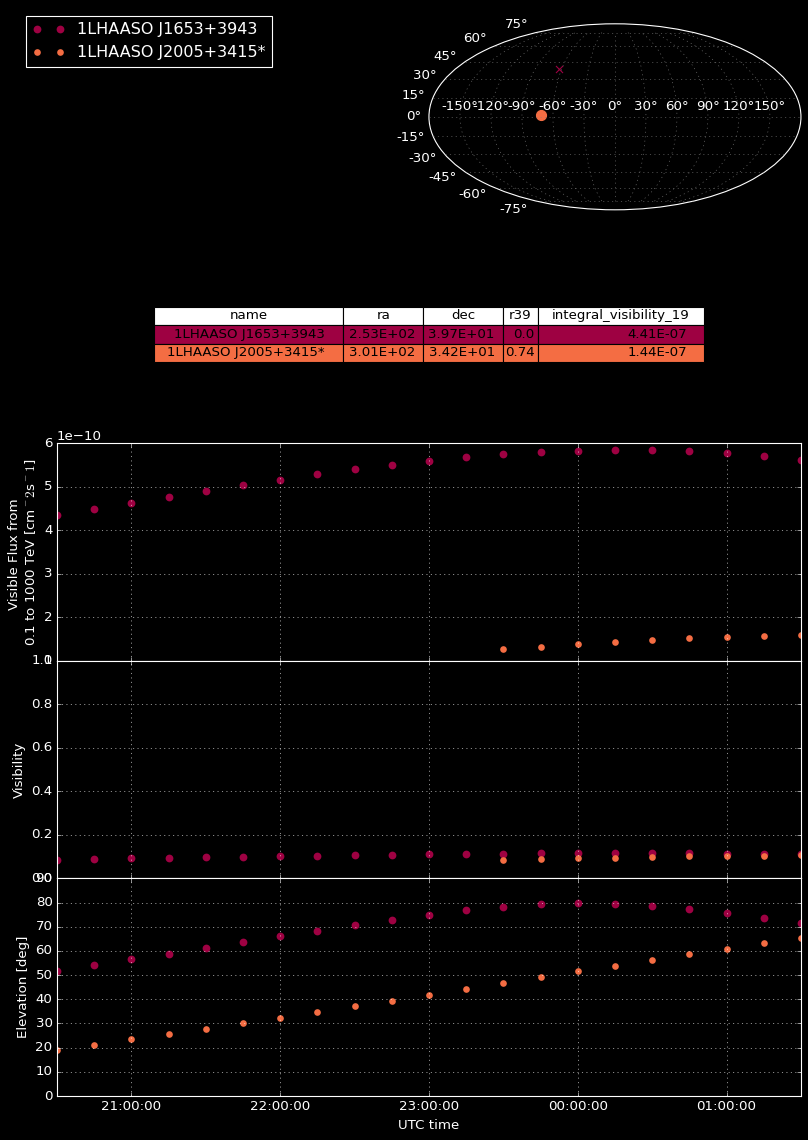

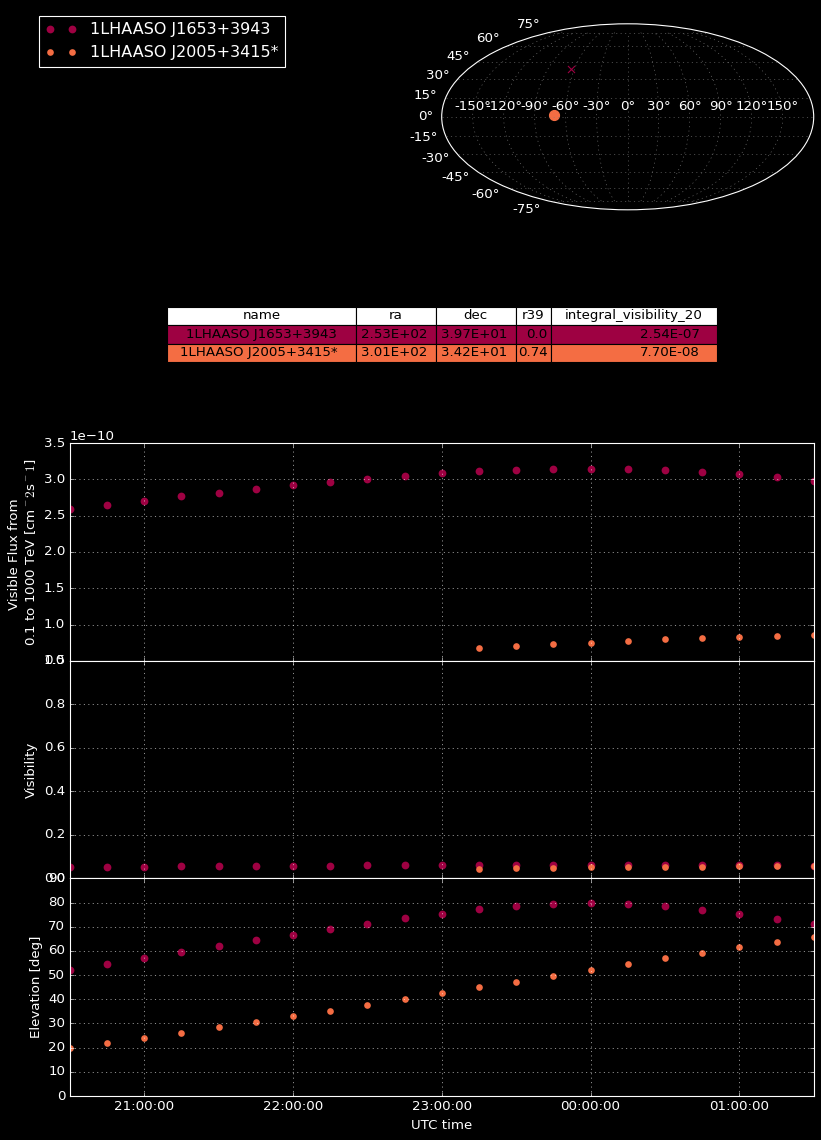

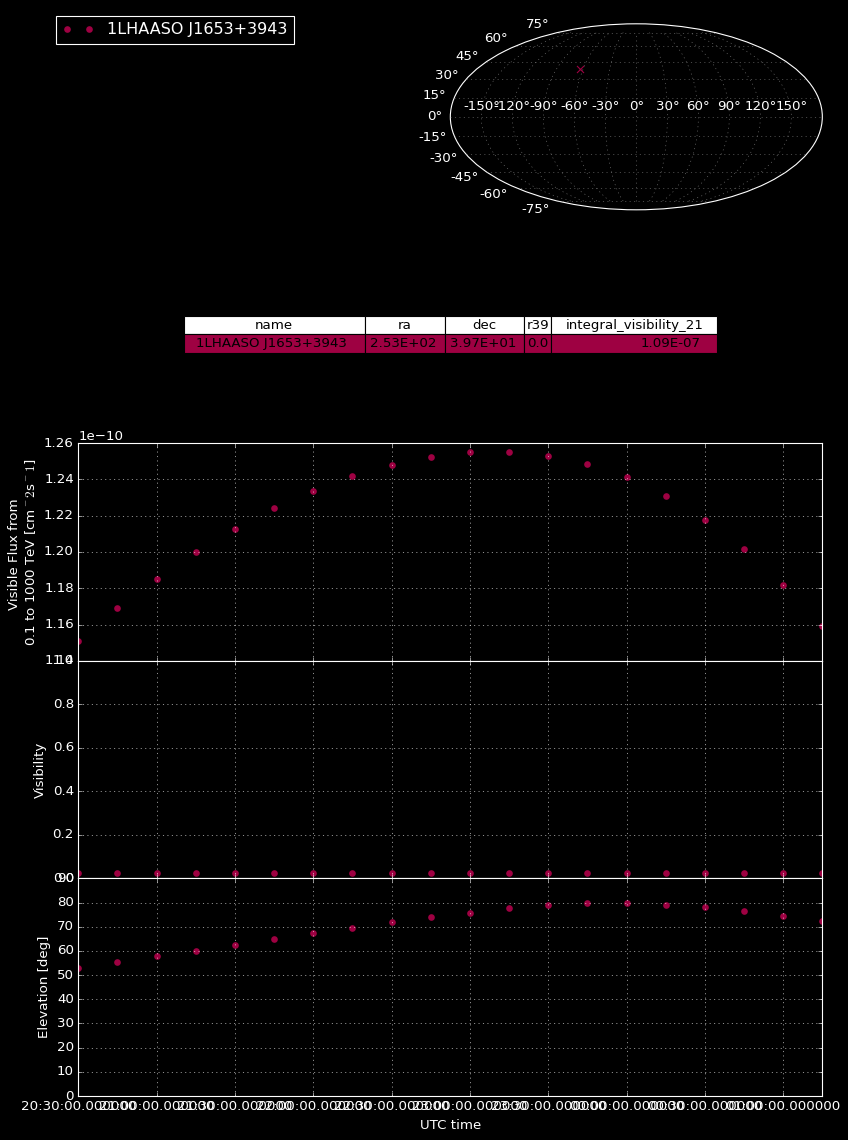

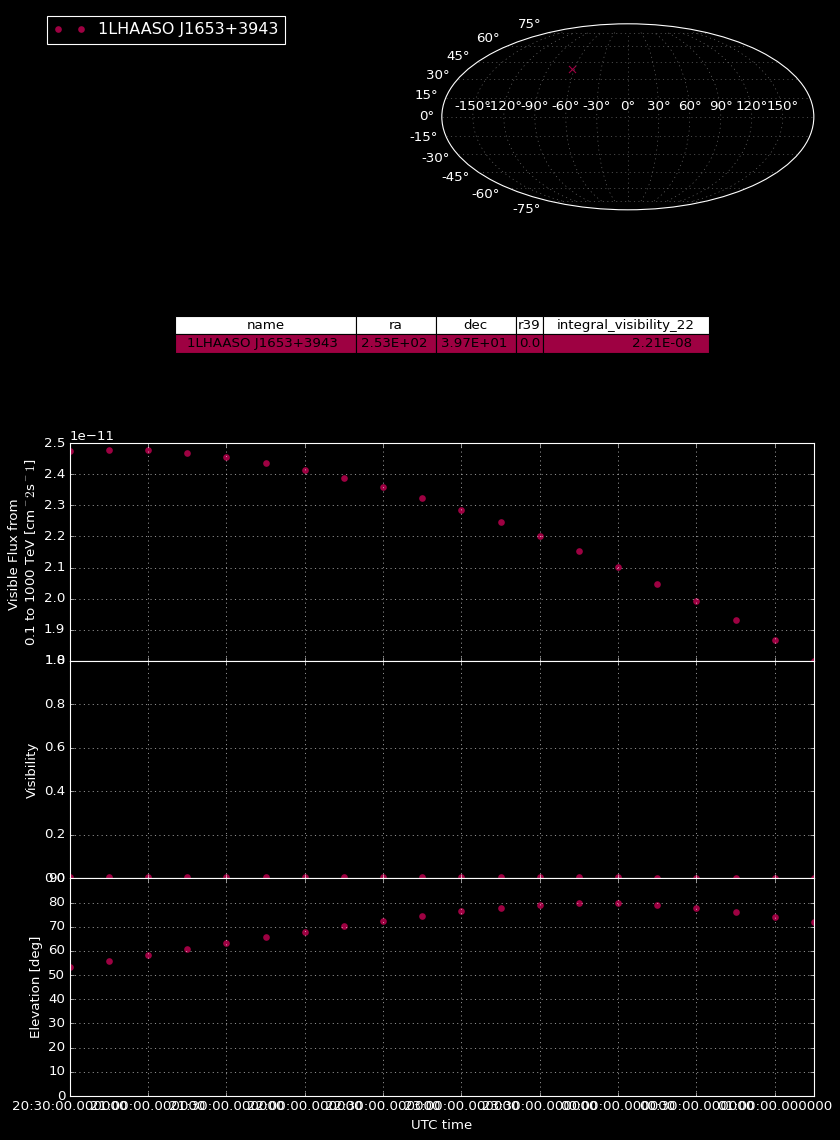

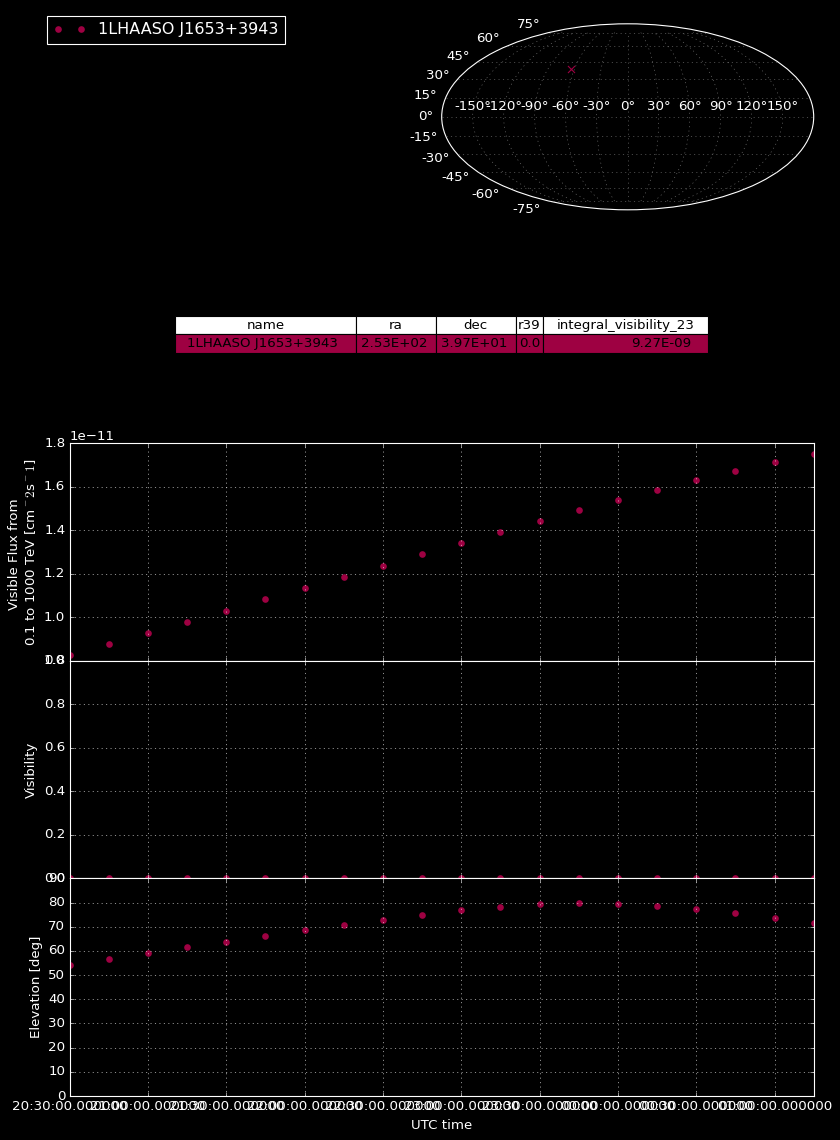

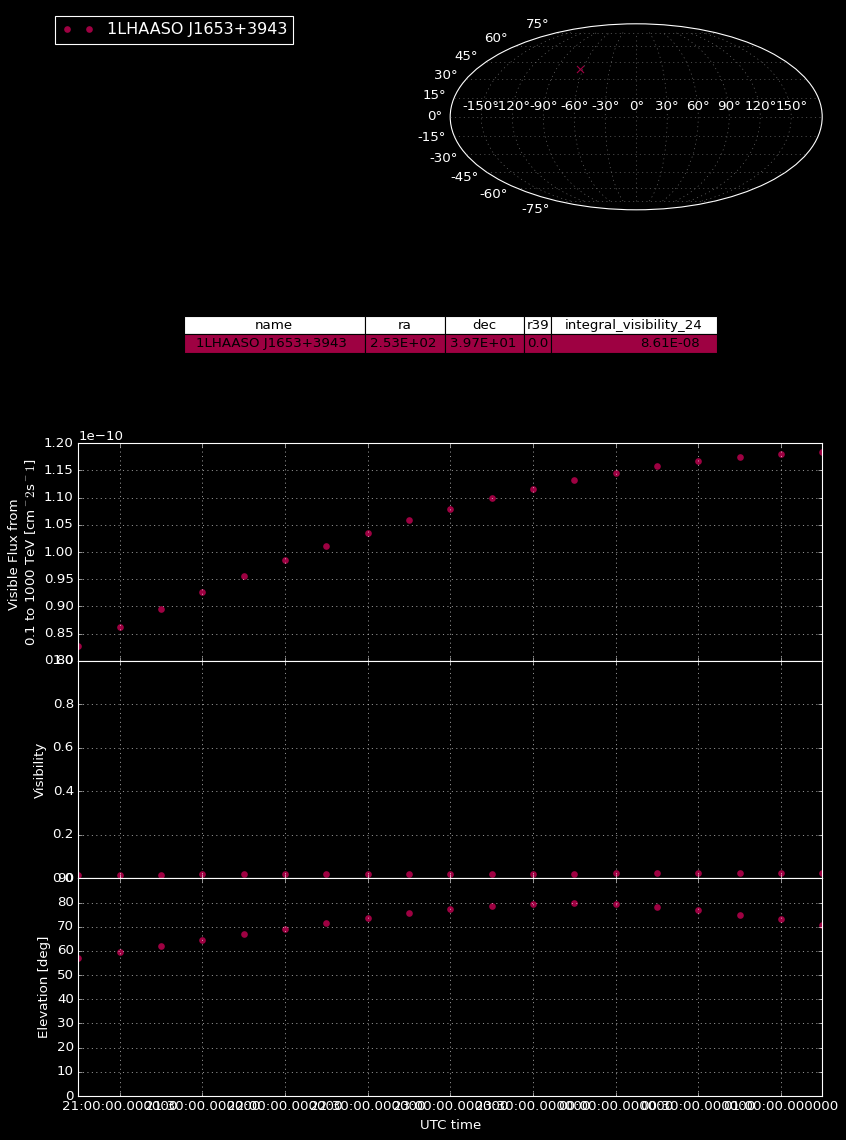

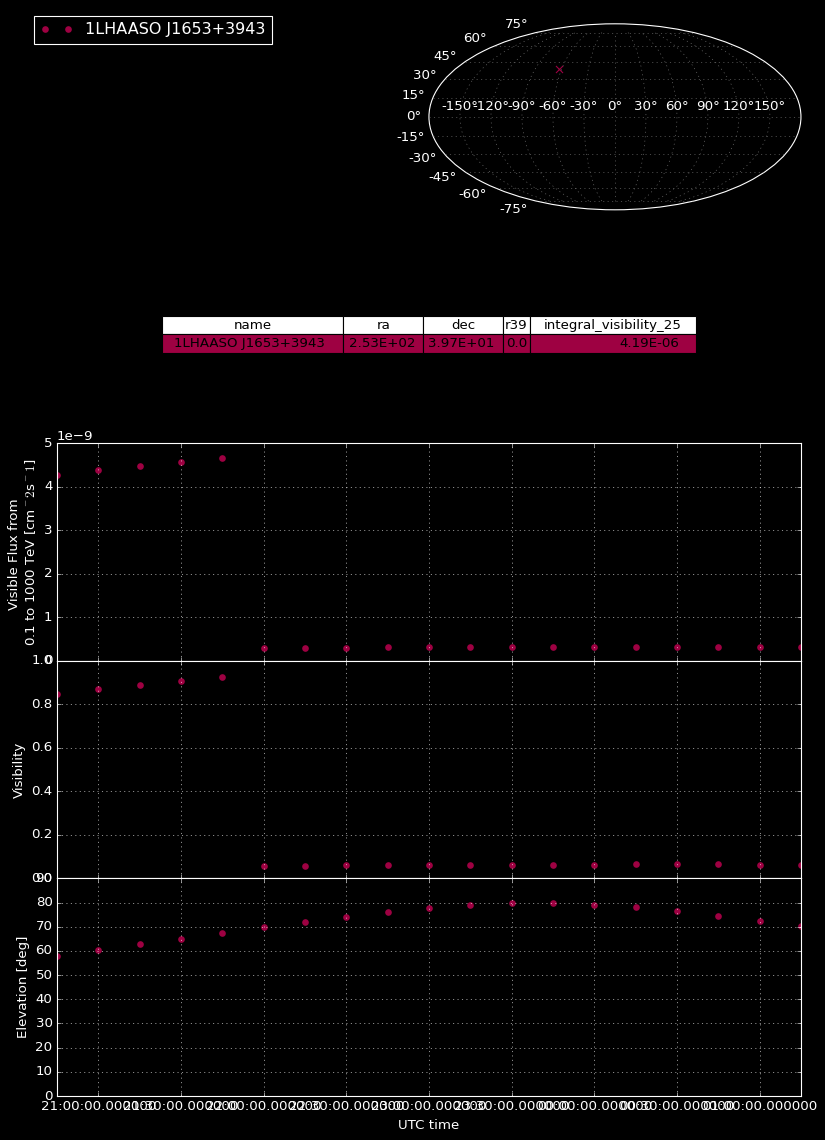

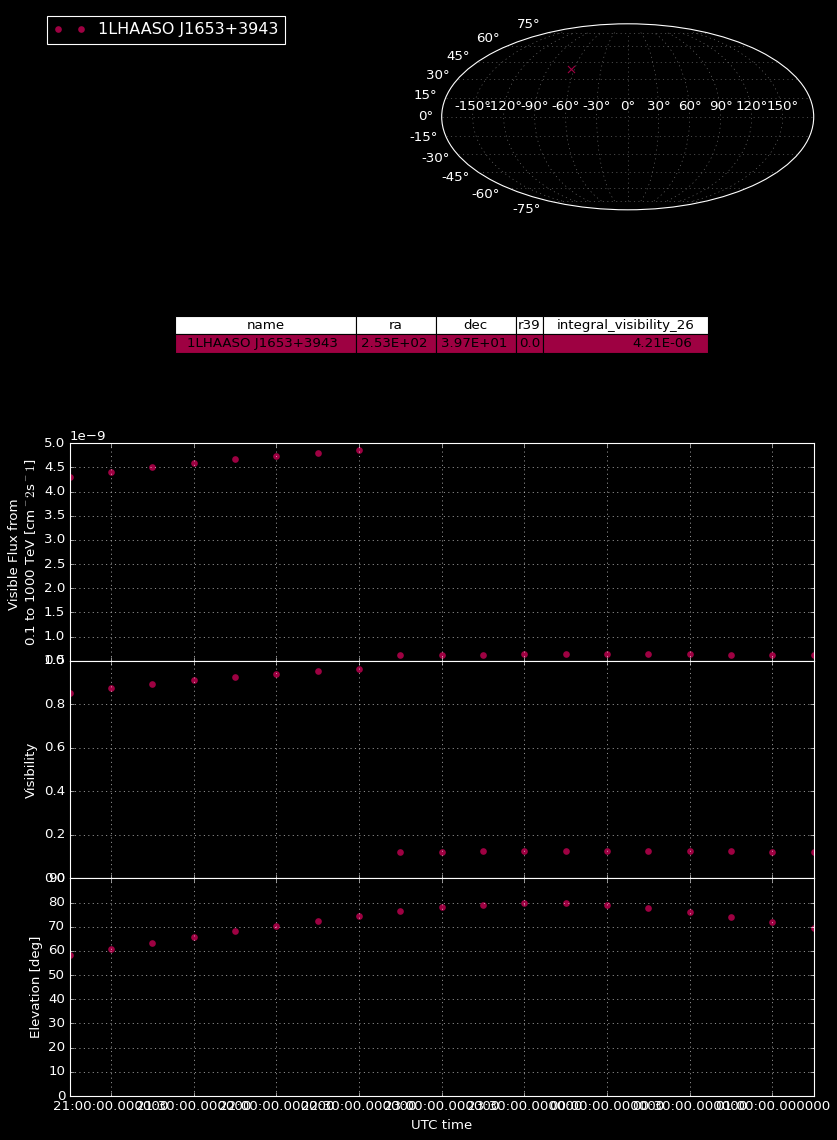

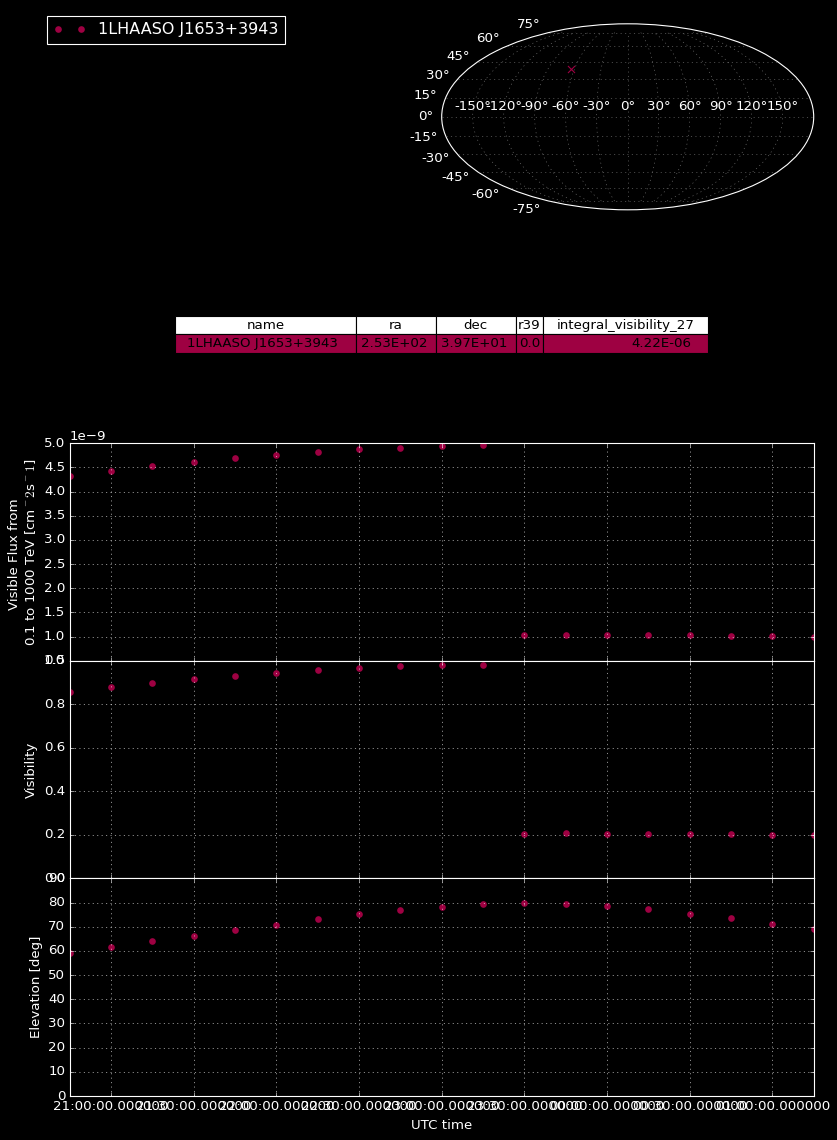

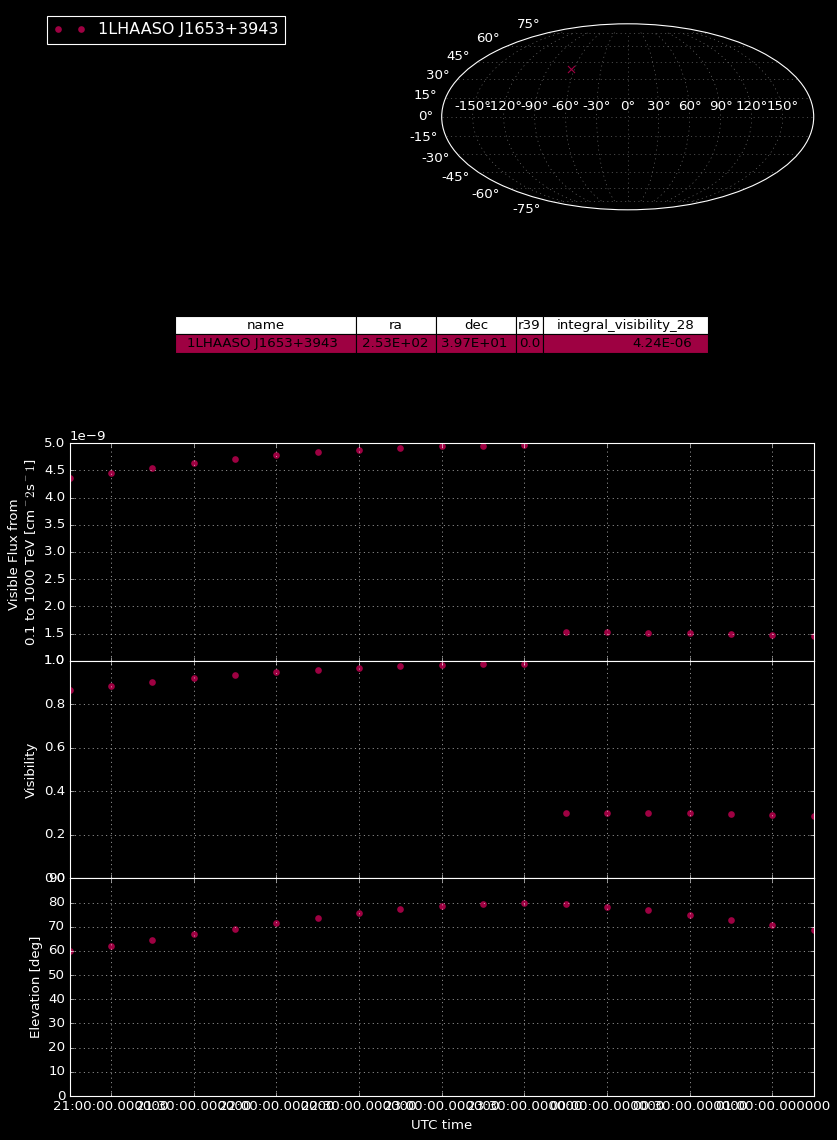

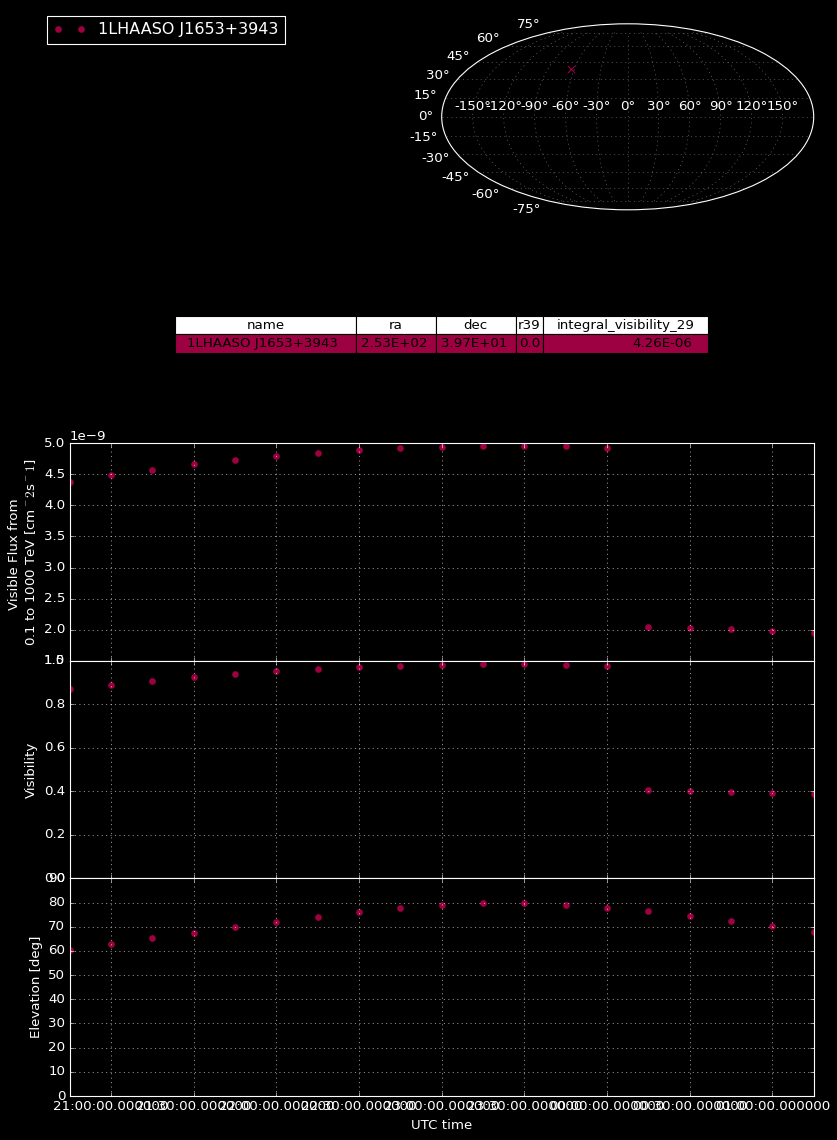

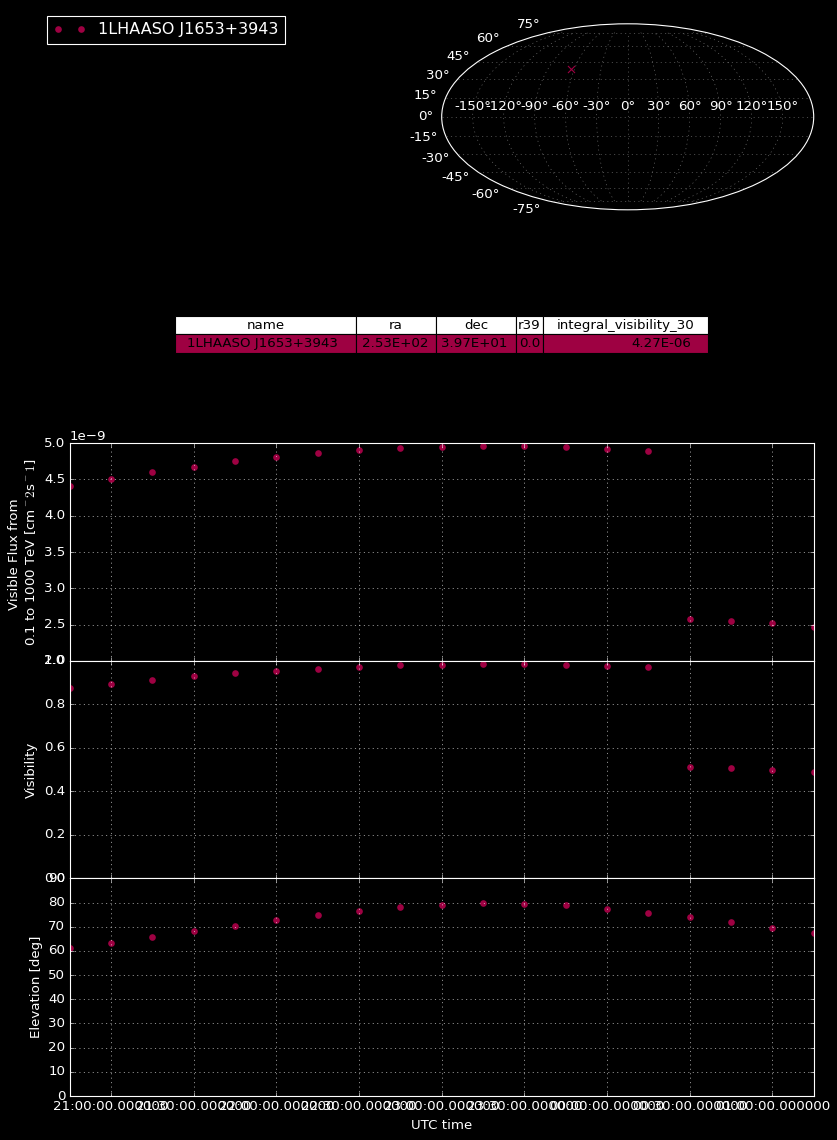

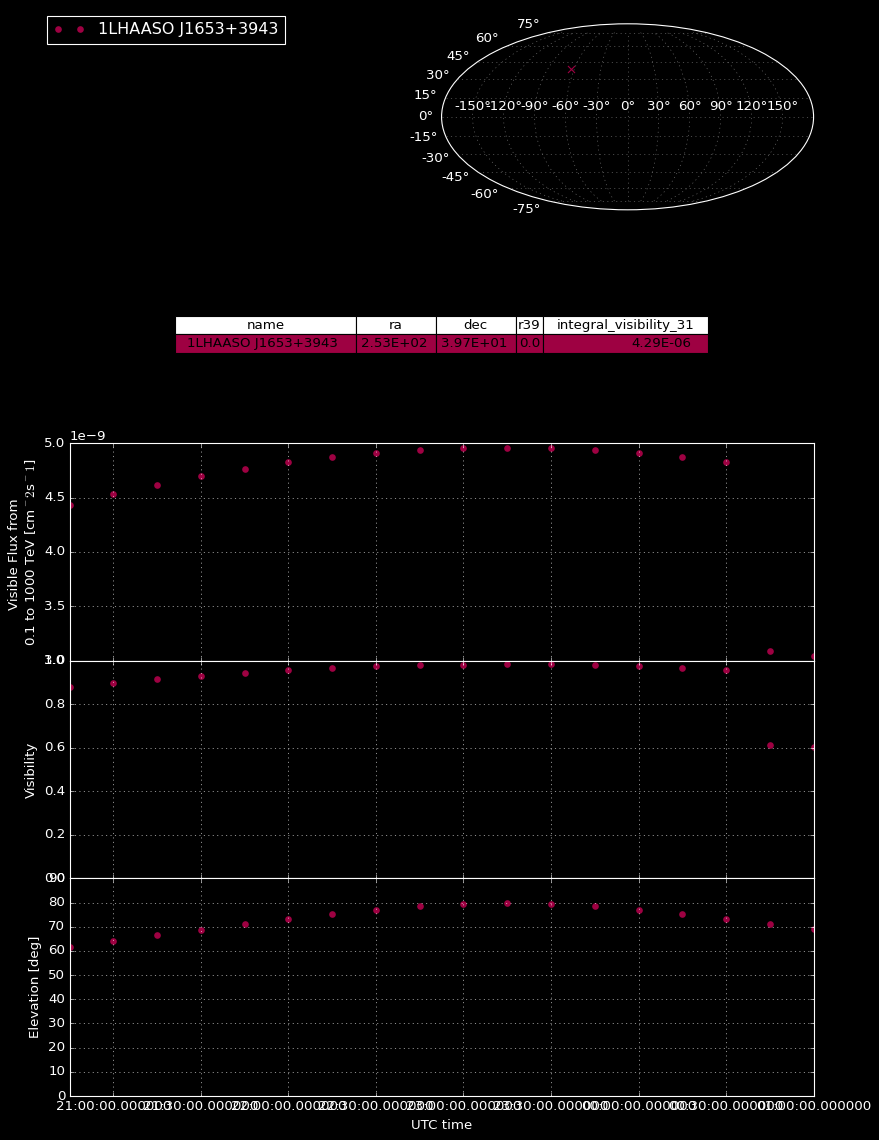

In [28]:
plots_LHAASO(gammacat, 5, 31)